<a href="https://colab.research.google.com/github/lukasdekanovsky/Become_PythonDeveloper_AI/blob/main/TRANSFER_LEARNING_(TL)_s%C3%ADt%C4%9B_vgg16_pro_obr%C3%A1zky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Transfer learning** - cílem je využít předtrénovanou neuronovou síť
* Následně využijeme její architekturu a natrénované parametry/váhy
* vytvoříme vlastní dopřednou část
* input je většinou definován funkcí od tvůrce velké neuronové sítě
* provedeme přeučení, kdy měníme váhy pouze u naší dopředné části
* Výsledkem je velice robusní predikce i bez velkého výpočetního výkonu


# **Import potřebných knihoven**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Naše dopředná část bude vyhodnocovat obrázky, proto si nahrajeme knihovny, moduly pro jejich preprocesing a augmentaci

In [ ]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# **Nahrání naučené neuronové sítě - VGG16**

https://neurohive.io/en/popular-networks/vgg16/

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input

* importujeme knihovnu s následujícími funkcemi:
* 1) PretrainedModel - natrénovaná architektura
* 2) preprocess_input - vývojářská funkce, která zprocesuje vstupní data tak, aby vyhovovala architektuře sítě


# **Nahrání našich trénovacích a testovacích dat**
* Budeme pracovat s fotkami 500x500 pixelu na kterých buťo je nebo není jidlo - binární klasifikace

In [ ]:
!wget -nc https://lazyprogrammer.me/course_files/Food-5K.zip
!unzip -qq -o Food-5K.zip
!mv Food-5K/* .

--2022-11-28 10:32:42--  https://lazyprogrammer.me/course_files/Food-5K.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 447001986 (426M) [application/zip]
Saving to: ‘Food-5K.zip’

Food-5K.zip         100%[===================>] 426.29M   626KB/s    in 21m 9s  

2022-11-28 10:53:52 (344 KB/s) - ‘Food-5K.zip’ saved [447001986/447001986]



* Prohlédneme si formát dat v datové sadě:
* Kategorizace je provedena v názvu obrázku 0_xxx.jpg a 1_xxx.jpg = je/není jidlo na obrázku

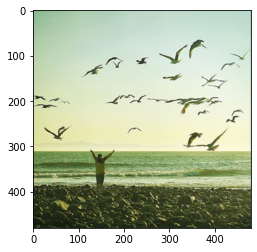

In [ ]:
plt.imshow(image.load_img('training/0_501.jpg'))
plt.show()

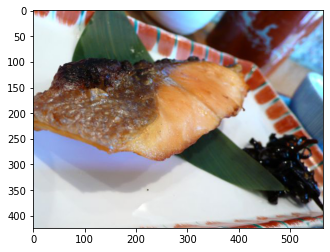

In [ ]:
plt.imshow(image.load_img('training/1_501.jpg'))
plt.show()

# **Příprava adresářové struktury našich nových dat, která potřebujeme přeučit s vgg16**

In [ ]:
#vytvoření adresářů
!mkdir data
!mkdir data/train
!mkdir data/test
!mkdir data/train/nonfood
!mkdir data/train/food
!mkdir data/test/nonfood
!mkdir data/test/food

#presun fotek do příslučních adresářů, začínající na 0 do nonfood a na 1 do food
!mv training/0*.jpg data/train/nonfood
!mv training/1*.jpg data/train/food
!mv validation/0*.jpg data/test/nonfood
!mv validation/1*.jpg data/test/food

#specifikace cest k datům
train_path = 'data/train'
valid_path = 'data/test'

* Ověříme si kolik máme obrzaových dat v každé kategorii


In [ ]:
from glob import glob

n_image_files = len(glob(train_path + '/*/*.jpg')) #počet trénovacích fotek
n_valid_image_files = len(glob(valid_path + '/*/*.jpg')) #počet testovacích fotek
K = len(glob(train_path + '/*')) #počet kategorií (jídlo, není jídlo)
print(n_image_files, n_valid_image_files, K)

3000 1000 2


* Provedeme datovou normalizaci - obrázky jsou příliš veliké, změnšíme je na 200x200 px
* Budeme učit po malých dávkách 128

In [ ]:
IMAGE_SIZE = [200, 200]
BATCH_SIZE = 128

# **Nahrání modelu naučené neuronové sítě vgg16**
* Sít se již nesmí přeučovat - bude se učit jen následně přidaná dopředná hlava

In [ ]:
# bylo nahráno tímto importem => from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input

In [ ]:
ptm = PretrainedModel(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
ptm.trainable = False

58889256/58889256 [==============================] - 0s 0us/step


# **Tvorba celkového modelu**

In [ ]:
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

model = Model(inputs=ptm.input, outputs=x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

# **Pro lepší výsledky by měla být provedena datová augmentace**

In [ ]:
gen_train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  preprocessing_function=preprocess_input
)

# **Úprava testovacích fotek**
* Vstupní fotky mohou být jakékoliv, proto nastavíme, že budou preprocesovány pomoci preprocesní funkce sítě VGG16, aby je síť přijala.

In [ ]:
gen_test = ImageDataGenerator(preprocessing_function=preprocess_input)

# **Nastavení modelu a jeho učení**

In [ ]:
train_generator = gen_train.flow_from_directory(train_path, shuffle=True, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,)
valid_generator = gen_test.flow_from_directory(valid_path, target_size=IMAGE_SIZE, batch_size=BATCH_SIZE,)

Found 3000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
r = model.fit_generator(
  train_generator,
  validation_data=valid_generator,
  epochs=10,
  steps_per_epoch=int(np.ceil(n_image_files / BATCH_SIZE)),
  validation_steps=int(np.ceil(n_valid_image_files / BATCH_SIZE)),
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
24/24 [==============================] - 1706s 71s/step - loss: 2.4244 - accuracy: 0.9010 - val_loss: 0.6666 - val_accuracy: 0.9780
Epoch 2/10
24/24 [==============================] - 1717s 72s/step - loss: 0.6599 - accuracy: 0.9730 - val_loss: 0.6563 - val_accuracy: 0.9790
Epoch 3/10
24/24 [==============================] - 1716s 72s/step - loss: 0.2822 - accuracy: 0.9830 - val_loss: 0.6642 - val_accuracy: 0.9810
Epoch 4/10
24/24 [==============================] - 1715s 72s/step - loss: 0.2319 - accuracy: 0.9860 - val_loss: 0.9791 - val_accuracy: 0.9770
Epoch 5/10
24/24 [==============================] - ETA: 0s - loss: 0.2627 - accuracy: 0.9843 

# **Vyhodnocení učení**

In [ ]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

In [ ]:
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

# **Nahrání vlastních dat:**

In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import decode_predictions

obrazek_cesta = "/content/data/test/nonfood/1_101.jpg"
obrazek = load_img(obrazek_cesta, target_size=IMAGE_SIZE)
obrazek = img_to_array(obrazek)
obrazek = obrazek.reshape((1, obrazek.shape[0], obrazek.shape[1], obrazek.shape[2]))
obrazek = preprocess_input(obrazek)

predpoved = model(obrazek)[0][0]
print(f"na obrazku je jidlo na {predpoved*100}%")